In [1]:
import json
import torch
import seaborn
import pylab as mpl
import matplotlib.pyplot as plt
from kt_ec_e2e_model import get_kt_batch, get_ec_batch, KT, KTData, ECData
from kt_ec_e2e_train import Trainer

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

print('torch.__version__: ', torch.__version__)
print('cuda.__version__: ', torch.version.cuda)
print(torch.cuda.is_available())

torch.__version__:  1.7.0+cu110
cuda.__version__:  11.0
True


In [2]:
n_question = 8
n_pid = 1500
seq_len = 30
n_blocks = 1
mid_size = 64
dropout = 0.05
epoch_num = 64

lr_ec = 1e-4
lr_kt = 2.5e-5
bs_ec = 16 
bs_kt = 2 
l2_ec = 1e-4
l2_kt = 2.5e-5
n_ec = 5
n_kt = 1
max_grad_norm = -1

In [3]:
name_dict = {'array': 0, 'hash-table': 1, 'math': 2, 'string': 3,
             'dynamic-programming': 4, 'greedy': 5, 'sorting': 6, 'depth-first-search': 7}

In [4]:
with open('./problem_data_a.json', 'r', encoding='utf8')as fp:
    data = json.load(fp)
with open('glove.6B.50d.txt', 'rb') as f:
    lines = f.readlines()
print('exer_num', len(data))

exer_num 1500


In [5]:
trained_dict = dict()
for i in range(len(lines)):
    line = lines[i].split()
    trained_dict[line[0].decode("utf-8").upper()] = [float(line[j]) for j in range(1, 51)]

In [6]:
glove = ECData(data=data, name_dict=name_dict, trained_dict=trained_dict, 
               train_path='./ec_train_data.json', test_path='./ec_test_data.json')
glove.get_words()
glove.get_id()

In [7]:
train_ec = get_ec_batch(glove.train_pid, glove.train_y, bs_ec)
test_ec = get_ec_batch(glove.test_pid, glove.test_y, bs_ec)
print('train_ec', len(train_ec), ', test_ec', len(test_ec))
print('test_rate', len(test_ec) / (len(test_ec) + len(train_ec)))

train_ec 81 , test_ec 12
test_rate 0.12903225806451613


In [8]:
data = KTData(n_question=n_question, seq_len=seq_len)
data.load_data('./exercise_data_b.txt', train_path='./kt_train_data.txt', test_path='./kt_test_data.txt')

In [9]:
train_kt = get_kt_batch(data.a_train, data.p_train, bs_kt)
test_kt = get_kt_batch(data.a_test, data.p_test, bs_kt)
print('train_kt', len(train_kt), ', test_kt', len(test_kt))
print('test_rate', len(test_kt) / (len(test_kt) + len(train_kt)))

train_kt 1438 , test_kt 635
test_rate 0.30631934394597204


In [10]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
tra_kt_loss, tes_kt_loss = list(), list()
tra_kt_acc1, tes_kt_acc1 = list(), list()
tra_kt_acc2, tes_kt_acc2 = list(), list()
tra_kt_acc3, tes_kt_acc3 = list(), list()
tra_kt_acc4, tes_kt_acc4 = list(), list()
tra_ec_loss, tes_ec_loss = list(), list()
tra_ec_acc1, tes_ec_acc1 = list(), list()
tra_ec_acc2, tes_ec_acc2 = list(), list()
tra_ec_acc3, tes_ec_acc3 = list(), list()
tra_ec_hit1, tes_ec_hit1 = list(), list()
tra_ec_hit2, tes_ec_hit2 = list(), list()
tra_ec_hit3, tes_ec_hit3 = list(), list()

In [11]:
kt_net = KT(ec_data=glove, n_question=n_question, n_pid=n_pid, 
            n_blocks=n_blocks, mid_size=mid_size, dropout=dropout)

d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [12]:
trainer = Trainer(net=kt_net, epoch_num=epoch_num, lr_ec=lr_ec, lr_kt=lr_kt, 
                  bs_ec=bs_ec, bs_kt=bs_kt, l2_ec=l2_ec, l2_kt=l2_kt, max_grad_norm=max_grad_norm)
epoch = 0

In [13]:
for epoch in range(epoch_num):
    loss_kt, loss_ec = 0, 0
    for i in range(n_kt):
        if epoch % 2 == 0:
            loss_kt = trainer.kt_func(train_kt) / len(train_kt) / bs_kt
            print("------- epoch %d, kt round %d -------"% (epoch + 1, i))
    for i in range(n_ec):
        loss_ec = trainer.ec_func(train_ec) / len(train_ec) / bs_ec
        print("------- epoch %d, ec round %d -------"% (epoch + 1, i))
    loss_tot = loss_kt + loss_ec

    tr_ec_loss, tr_ec_acc1, tr_ec_acc2, tr_ec_acc3, tr_ec_hit1, tr_ec_hit2, tr_ec_hit3 = trainer.ec_eval(train_ec)
    tr_kt_loss, tr_kt_acc1, tr_kt_acc2, tr_kt_acc3, tr_kt_acc4 = trainer.kt_eval(train_kt)
    te_ec_loss, te_ec_acc1, te_ec_acc2, te_ec_acc3, te_ec_hit1, te_ec_hit2, te_ec_hit3 = trainer.ec_eval(test_ec)
    te_kt_loss, te_kt_acc1, te_kt_acc2, te_kt_acc3, te_kt_acc4 = trainer.kt_eval(test_kt)
    
    if epoch % 25 == 0 or (len(tra_ec_acc2) > 0 and tr_ec_acc2 - tra_ec_acc2[-1] > 0.049):
        torch.save(trainer.net.ec_net.state_dict(), './results/ec_e2e_epoch/ec_e2e_epoch_%d.pt' % epoch)

    tra_kt_loss.append(tr_kt_loss / len(train_kt) / bs_kt)
    tes_kt_loss.append(te_kt_loss / len(test_kt) / bs_kt)
    tra_kt_acc1.append(tr_kt_acc1)
    tes_kt_acc1.append(te_kt_acc1)
    tra_kt_acc2.append(tr_kt_acc2)
    tes_kt_acc2.append(te_kt_acc2)
    tra_kt_acc3.append(tr_kt_acc3)
    tes_kt_acc3.append(te_kt_acc3)
    tra_kt_acc4.append(tr_kt_acc4)
    tes_kt_acc4.append(te_kt_acc4)
    tra_ec_loss.append(tr_ec_loss / len(train_ec) / bs_ec)
    tes_ec_loss.append(te_ec_loss / len(test_ec) / bs_ec)
    tra_ec_acc1.append(tr_ec_acc1)
    tes_ec_acc1.append(te_ec_acc1)
    tra_ec_acc2.append(tr_ec_acc2)
    tes_ec_acc2.append(te_ec_acc2)
    tra_ec_acc3.append(tr_ec_acc3)
    tes_ec_acc3.append(te_ec_acc3)
    tra_ec_hit1.append(tr_ec_hit1)
    tes_ec_hit1.append(te_ec_hit1)
    tra_ec_hit2.append(tr_ec_hit2)
    tes_ec_hit2.append(te_ec_hit2)
    tra_ec_hit3.append(tr_ec_hit3)
    tes_ec_hit3.append(te_ec_hit3)
    print("----------- iteration", epoch + 1, "-----------")
    print("total loss:", loss_tot)
    print("kt train loss:", tr_kt_loss / len(train_kt), ", ", "ec train loss:", tr_ec_loss / len(train_ec))
    print("kt train acc:", tr_kt_acc2, ", ", "kt test acc:", te_kt_acc2)
    print("ec train acc:", tr_ec_acc1, ", ", "ec test acc:", te_ec_acc1)
    if tr_ec_acc1 > 0.8 and te_ec_acc1 > 0.38 and te_kt_acc2 > 0.9:
        break

------- epoch 1, kt round 0 -------
------- epoch 1, ec round 0 -------
------- epoch 1, ec round 1 -------
------- epoch 1, ec round 2 -------
------- epoch 1, ec round 3 -------
------- epoch 1, ec round 4 -------


D:\PyCharmProjects\ecnu-EduKTM\paper2a\kt_ec_e2e_train.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean((torch.tensor(pred == y, dtype=torch.float)))
D:\PyCharmProjects\ecnu-EduKTM\paper2a\kt_ec_e2e_train.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean(torch.tensor(pred == y, dtype=torch.float))


----------- iteration 1 -----------
total loss: tensor([3.7245], device='cuda:0')
kt train loss: 4.356144023004476 ,  ec train loss: 6.93958200643092
kt train acc: 0.27573018080667594 ,  kt test acc: 0.2952755905511811
ec train acc: 0.013117283950617283 ,  ec test acc: 0.010416666666666666
------- epoch 2, ec round 0 -------
------- epoch 2, ec round 1 -------
------- epoch 2, ec round 2 -------
------- epoch 2, ec round 3 -------
------- epoch 2, ec round 4 -------
----------- iteration 2 -----------
total loss: tensor([0.3881], device='cuda:0')
kt train loss: 5.107800152056277 ,  ec train loss: 5.9645287313579045
kt train acc: 0.26286509040333794 ,  kt test acc: 0.27086614173228346
ec train acc: 0.12885802469135801 ,  ec test acc: 0.1875
------- epoch 3, kt round 0 -------
------- epoch 3, ec round 0 -------
------- epoch 3, ec round 1 -------
------- epoch 3, ec round 2 -------
------- epoch 3, ec round 3 -------
------- epoch 3, ec round 4 -------
----------- iteration 3 ----------

------- epoch 18, ec round 3 -------
------- epoch 18, ec round 4 -------
----------- iteration 18 -----------
total loss: tensor([0.1505], device='cuda:0')
kt train loss: 0.5067748487611973 ,  ec train loss: 2.2849344044555853
kt train acc: 0.8974269819193325 ,  kt test acc: 0.8866141732283465
ec train acc: 0.4807098765432099 ,  ec test acc: 0.3125
------- epoch 19, kt round 0 -------
------- epoch 19, ec round 0 -------
------- epoch 19, ec round 1 -------
------- epoch 19, ec round 2 -------
------- epoch 19, ec round 3 -------
------- epoch 19, ec round 4 -------
----------- iteration 19 -----------
total loss: tensor([0.3439], device='cuda:0')
kt train loss: 0.9002645098405458 ,  ec train loss: 2.091164747873942
kt train acc: 0.8929068150208623 ,  kt test acc: 0.8874015748031496
ec train acc: 0.6057098765432098 ,  ec test acc: 0.3333333333333333
------- epoch 20, ec round 0 -------
------- epoch 20, ec round 1 -------
------- epoch 20, ec round 2 -------
------- epoch 20, ec round

------- epoch 35, kt round 0 -------
------- epoch 35, ec round 0 -------
------- epoch 35, ec round 1 -------
------- epoch 35, ec round 2 -------
------- epoch 35, ec round 3 -------
------- epoch 35, ec round 4 -------
----------- iteration 35 -----------
total loss: tensor([0.2039], device='cuda:0')
kt train loss: 0.4287243281706545 ,  ec train loss: 0.852813325546406
kt train acc: 0.9401947148817803 ,  kt test acc: 0.9283464566929134
ec train acc: 0.8009259259259259 ,  ec test acc: 0.359375
------- epoch 36, ec round 0 -------
------- epoch 36, ec round 1 -------
------- epoch 36, ec round 2 -------
------- epoch 36, ec round 3 -------
------- epoch 36, ec round 4 -------
----------- iteration 36 -----------
total loss: tensor([0.0479], device='cuda:0')
kt train loss: 0.4362853837854925 ,  ec train loss: 0.8025502319689151
kt train acc: 0.9447148817802503 ,  kt test acc: 0.9338582677165355
ec train acc: 0.8194444444444444 ,  ec test acc: 0.34375
------- epoch 37, kt round 0 ------

In [14]:
epoch += 1 

trainer.model_save(epoch, n_ec=n_ec, n_kt=n_kt, path='./results/ec+kt+e2e_model.pth')

In [15]:
trainer.ec_valid(glove, './results/ec+kt+e2e_valid_ec.json')

In [16]:
trainer.kt_valid('./exercise_data_b.txt', './results/ec+kt+e2e_valid_kt.txt')

In [17]:
print('train_kt_acc_single:', tra_kt_acc1[-1], ', train_kt_acc_every:', tra_kt_acc2[-1])
print('train_kt_acc_right:', tra_kt_acc3[-1], ', train_kt_acc_wrong:', tra_kt_acc4[-1])
print('test_kt_acc_single:', tes_kt_acc1[-1], ', test_kt_acc_every:', tes_kt_acc2[-1])
print('test_kt_acc_right:', tes_kt_acc3[-1], ', test_kt_acc_wrong:', tes_kt_acc4[-1])

train_kt_acc_single: 0.9971275936827706 , train_kt_acc_every: 0.9381084840055632
train_kt_acc_right: 0.996852563302938 , train_kt_acc_wrong: 0.9966839320636426
test_kt_acc_single: 0.9960893461084741 , test_kt_acc_every: 0.9236220472440945
test_kt_acc_right: 0.9960788848831897 , test_kt_acc_wrong: 0.9933723422486013


In [18]:
print('train_ec_acc_every:', tra_ec_acc1[-1], ', train_ec_acc_partof:', tra_ec_acc2[-1], ', train_ec_acc_single:', tra_ec_acc3[-1])
print('test_ec_acc_every:', tes_ec_acc1[-1], ', test_ec_acc_partof:', tes_ec_acc2[-1], ', test_ec_acc_single:', tes_ec_acc3[-1])
print('train_ec_recall:', tra_ec_hit2[-1], ', train_ec_precision:', tra_ec_hit1[-1], ', train_ec_F1:', tra_ec_hit3[-1])
print('test_ec_recall:', tes_ec_hit2[-1], ', test_ec_precision:', tes_ec_hit1[-1], ', test_ec_F1:', tes_ec_hit3[-1])

train_ec_acc_every: 0.8595679012345679 , train_ec_acc_partof: 0.9243827160493827 , train_ec_acc_single: 0.9802276234567902
test_ec_acc_every: 0.3802083333333333 , test_ec_acc_partof: 0.6041666666666666 , test_ec_acc_single: 0.8802083333333334
train_ec_recall: 0.9428371706126649 , train_ec_precision: 0.9963992002569599 , train_ec_F1: 0.9688784893712714
test_ec_recall: 0.7165813893079758 , test_ec_precision: 0.7977443238099416 , test_ec_F1: 0.7549878218620283


In [19]:
print('train_ec_acc_every_max:', max(tra_ec_acc1), ', train_ec_acc_partof_max:', max(tra_ec_acc2), ', train_ec_acc_single_max:', max(tra_ec_acc3))
print('test_ec_acc_every_max:', max(tes_ec_acc1), ', test_ec_acc_partof_max:', max(tes_ec_acc2), ', test_ec_acc_single_max:', max(tes_ec_acc3))
print('train_ec_recall_max:', max(tra_ec_hit2), ', train_ec_precision_max:', max(tra_ec_hit1), ', train_ec_F1_max:', max(tra_ec_hit3))
print('test_ec_recall_max:', max(tes_ec_hit2), ', test_ec_precision_max:', max(tes_ec_hit1), ', test_ec_F1_max:', max(tes_ec_hit3))

train_ec_acc_every_max: 0.8765432098765432 , train_ec_acc_partof_max: 0.9266975308641975 , train_ec_acc_single_max: 0.9825424382716049
test_ec_acc_every_max: 0.3802083333333333 , test_ec_acc_partof_max: 0.6041666666666666 , test_ec_acc_single_max: 0.8860677083333334
train_ec_recall_max: 0.9502316875222289 , train_ec_precision_max: 0.99704220265518 , train_ec_F1_max: 0.9730743061250575
test_ec_recall_max: 0.7977441002925237 , test_ec_precision_max: 0.8350704809029897 , test_ec_F1_max: 0.7720554291217907


In [20]:
file = open("./results/ec+kt+e2e_desc.txt",'w') 
print('train_kt_acc_single:', tra_kt_acc1[-1], ', train_kt_acc_every:', tra_kt_acc2[-1], file=file)
print('train_kt_acc_right:', tra_kt_acc3[-1], ', train_kt_acc_wrong:', tra_kt_acc4[-1], file=file)
print('test_kt_acc_single:', tes_kt_acc1[-1], ', test_kt_acc_every:', tes_kt_acc2[-1], file=file)
print('test_kt_acc_right:', tes_kt_acc3[-1], ', test_kt_acc_wrong:', tes_kt_acc4[-1], file=file)
print('', file=file)
print('train_ec_acc_every:', tra_ec_acc1[-1], ', train_ec_acc_partof:', tra_ec_acc2[-1], ', train_ec_acc_single:', tra_ec_acc3[-1], file=file)
print('test_ec_acc_every:', tes_ec_acc1[-1], ', test_ec_acc_partof:', tes_ec_acc2[-1], ', test_ec_acc_single:', tes_ec_acc3[-1], file=file)
print('train_ec_recall:', tra_ec_hit2[-1], ', train_ec_precision:', tra_ec_hit1[-1], ', train_ec_F1:', tra_ec_hit3[-1], file=file)
print('test_ec_recall:', tes_ec_hit2[-1], ', test_ec_precision:', tes_ec_hit1[-1], ', test_ec_F1:', tes_ec_hit3[-1], file=file)
print('', file=file)
print('train_ec_acc_every_max:', max(tra_ec_acc1), ', train_ec_acc_partof_max:', max(tra_ec_acc2), ', train_ec_acc_single_max:', max(tra_ec_acc3), file=file)
print('test_ec_acc_every_max:', max(tes_ec_acc1), ', test_ec_acc_partof_max:', max(tes_ec_acc2), ', test_ec_acc_single_max:', max(tes_ec_acc3), file=file)
print('train_ec_recall_max:', max(tra_ec_hit2), ', train_ec_precision_max:', max(tra_ec_hit1), ', train_ec_F1_max:', max(tra_ec_hit3), file=file)
print('test_ec_recall_max:', max(tes_ec_hit2), ', test_ec_precision_max:', max(tes_ec_hit1), ', test_ec_F1_max:', max(tes_ec_hit3), file=file)
print('', file=file)
print('train_kt_acc_single:', tra_kt_acc1, file=file)
print('train_kt_acc_every:', tra_kt_acc2, file=file)
print('train_kt_acc_right:', tra_kt_acc3, file=file)
print('train_kt_acc_wrong:', tra_kt_acc4, file=file)
print('test_kt_acc_single:', tes_kt_acc1, file=file)
print('test_kt_acc_every:', tes_kt_acc2, file=file)
print('test_kt_acc_right:', tes_kt_acc3, file=file)
print('test_kt_acc_wrong:', tes_kt_acc4, file=file)
print('', file=file)
print('train_ec_acc_every:', tra_ec_acc1, file=file)
print('train_ec_acc_partof:', tra_ec_acc2, file=file)
print('train_ec_acc_single:', tra_ec_acc3, file=file)
print('test_ec_acc_every:', tes_ec_acc1, file=file)
print('test_ec_acc_partof:', tes_ec_acc2, file=file)
print('test_ec_acc_single:', tes_ec_acc3, file=file)
print('train_ec_recall:', tra_ec_hit2, file=file)
print('train_ec_precision:', tra_ec_hit1, file=file)
print('train_ec_F1:', tra_ec_hit3, file=file)
print('test_ec_recall:', tes_ec_hit2, file=file)
print('test_ec_precision:', tes_ec_hit1, file=file)
print('test_ec_F1:', tes_ec_hit3, file=file)
file.close()

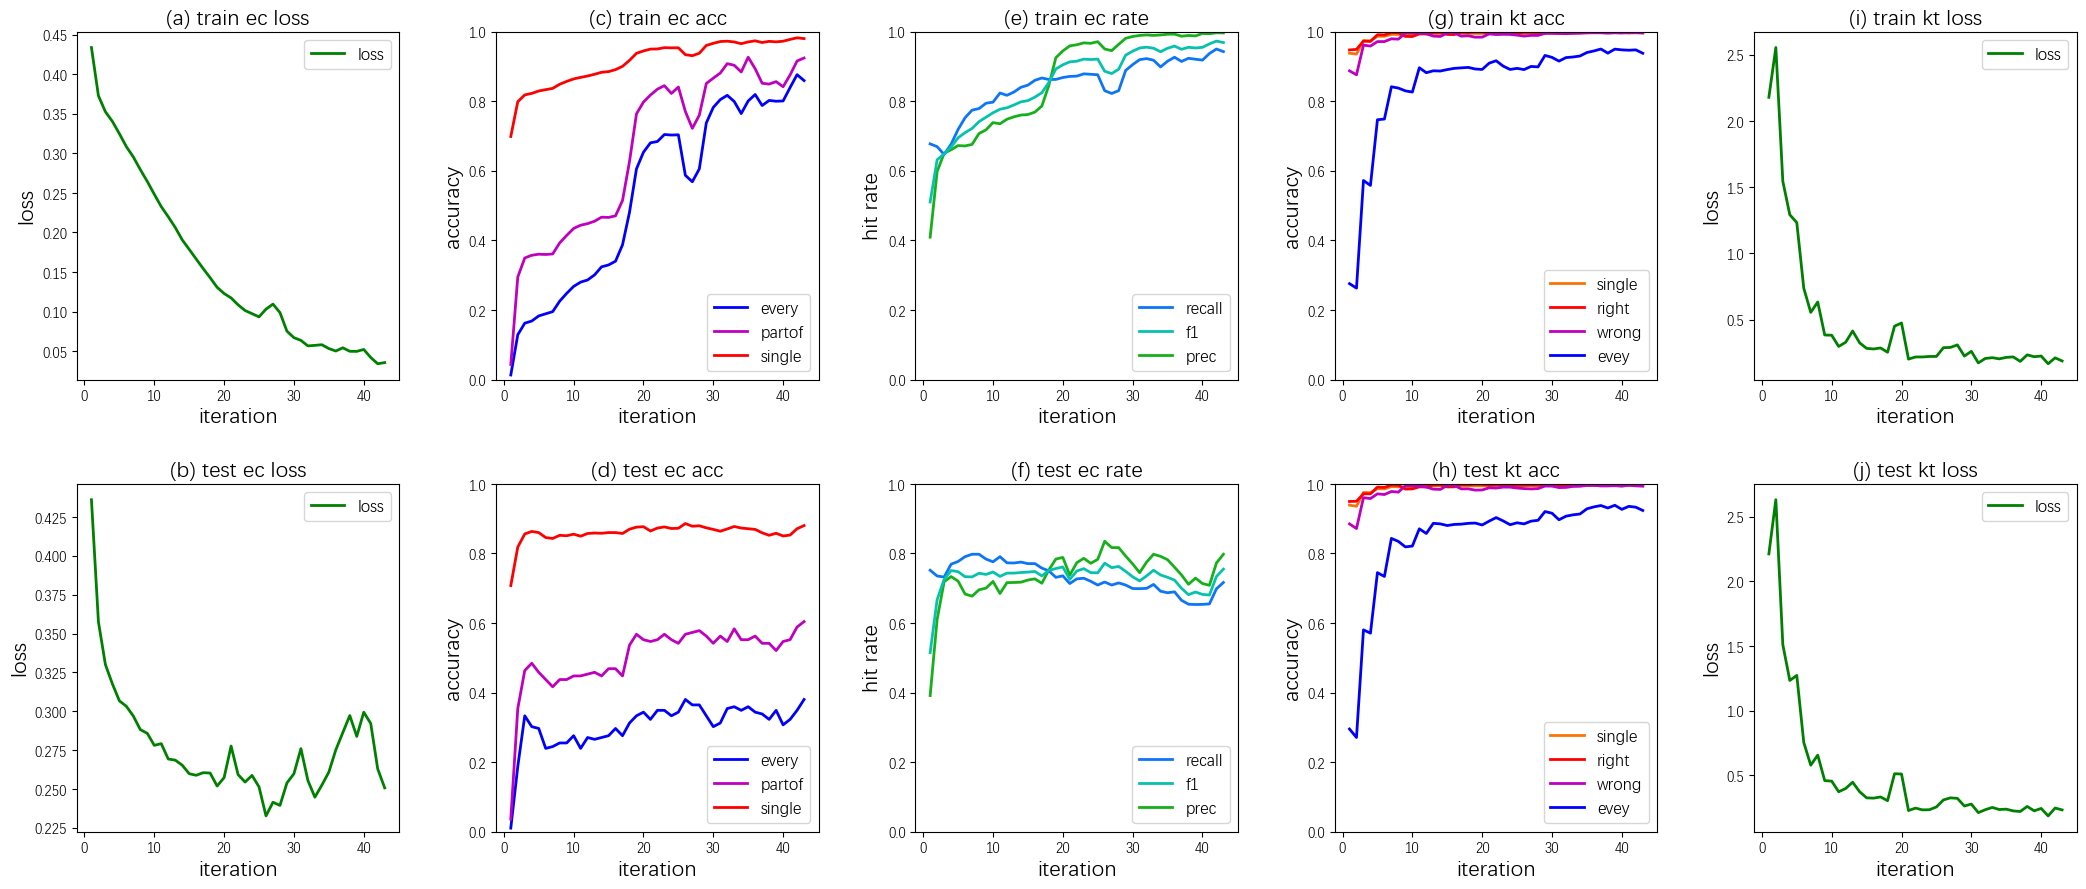

In [21]:
x_range = list(range(1, len(tra_ec_loss) + 1))
fig = plt.figure(num=1, figsize=(25, 10), dpi=100, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(2, 5, 1)
ax2 = fig.add_subplot(2, 5, 6)
ax3 = fig.add_subplot(2, 5, 2)
ax4 = fig.add_subplot(2, 5, 7)
ax5 = fig.add_subplot(2, 5, 3)
ax6 = fig.add_subplot(2, 5, 8)
ax7 = fig.add_subplot(2, 5, 4)
ax8 = fig.add_subplot(2, 5, 9)
ax9 = fig.add_subplot(2, 5, 5)
ax0 = fig.add_subplot(2, 5, 10)

l1, = ax1.plot(x_range, tra_ec_loss, c='g', lw='2')
ax1.set_title('(a) train ec loss', fontsize=16)
ax1.set_xlabel('iteration', fontsize=16)
ax1.set_ylabel('loss', fontsize=16)
ax1.legend([l1, ], ['loss'], loc='upper right', fontsize=12)  

l1, = ax2.plot(x_range, tes_ec_loss, c='g', lw='2')
ax2.set_title('(b) test ec loss', fontsize=16)
ax2.set_xlabel('iteration', fontsize=16)
ax2.set_ylabel('loss', fontsize=16)
ax2.legend([l1, ], ['loss', ], loc='upper right', fontsize=12)  

l1,  = ax3.plot(x_range, tra_ec_acc1, c='b', lw='2')
l2,  = ax3.plot(x_range, tra_ec_acc2, c='m', lw='2')
l3,  = ax3.plot(x_range, tra_ec_acc3, c='r', lw='2')
ax3.set_title('(c) train ec acc', fontsize=16)
ax3.set_xlabel('iteration', fontsize=16)
ax3.set_ylabel('accuracy', fontsize=16)
ax3.set_ylim((0, 1))
ax3.legend([l1, l2, l3], ['every', 'partof', 'single'], loc='lower right', fontsize=12)  

l1,  = ax4.plot(x_range, tes_ec_acc1, c='b', lw='2')
l2,  = ax4.plot(x_range, tes_ec_acc2, c='m', lw='2')
l3,  = ax4.plot(x_range, tes_ec_acc3, c='r', lw='2')
ax4.set_title('(d) test ec acc', fontsize=16)
ax4.set_xlabel('iteration', fontsize=16)
ax4.set_ylabel('accuracy', fontsize=16)
ax4.set_ylim((0, 1))
ax4.legend([l1, l2, l3], ['every', 'partof', 'single'], loc='lower right', fontsize=12)  

l1,  = ax5.plot(x_range, tra_ec_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax5.plot(x_range, tra_ec_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax5.plot(x_range, tra_ec_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax5.set_title('(e) train ec rate', fontsize=16)
ax5.set_xlabel('iteration', fontsize=16)
ax5.set_ylabel('hit rate', fontsize=16)
ax5.set_ylim((0, 1))
ax5.legend([l2, l3, l1], ['recall', 'f1', 'prec'], loc='lower right', fontsize=12)  

l1,  = ax6.plot(x_range, tes_ec_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax6.plot(x_range, tes_ec_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax6.plot(x_range, tes_ec_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax6.set_title('(f) test ec rate', fontsize=16)
ax6.set_xlabel('iteration', fontsize=16)
ax6.set_ylabel('hit rate', fontsize=16)
ax6.set_ylim((0, 1))
ax6.legend([l2, l3, l1], ['recall', 'f1', 'prec'], loc='lower right', fontsize=12)  

l1, = ax9.plot(x_range, tra_kt_loss, c='g', lw='2')
ax9.set_title('(i) train kt loss', fontsize=16)
ax9.set_xlabel('iteration', fontsize=16)
ax9.set_ylabel('loss', fontsize=16)
ax9.legend([l1, ], ['loss'], loc='upper right', fontsize=12)  

l1, = ax0.plot(x_range, tes_kt_loss, c='g', lw='2')
ax0.set_title('(j) test kt loss', fontsize=16)
ax0.set_xlabel('iteration', fontsize=16)
ax0.set_ylabel('loss', fontsize=16)
ax0.legend([l1, ], ['loss', ], loc='upper right', fontsize=12)  

l1, = ax7.plot(x_range, tra_kt_acc1, c=seaborn.xkcd_rgb['orange'], lw='2')
l2, = ax7.plot(x_range, tra_kt_acc3, c='r', lw='2')
l3, = ax7.plot(x_range, tra_kt_acc4, c='m', lw='2')
l4, = ax7.plot(x_range, tra_kt_acc2, c='b', lw='2')
ax7.set_title('(g) train kt acc', fontsize=16)
ax7.set_xlabel('iteration', fontsize=16)
ax7.set_ylabel('accuracy', fontsize=16)
ax7.set_ylim((0, 1))
ax7.legend([l1, l2, l3, l4], ['single', 'right', 'wrong', 'evey'], loc='lower right', fontsize=12)  

l1, = ax8.plot(x_range, tes_kt_acc1, c=seaborn.xkcd_rgb['orange'], lw='2')
l2, = ax8.plot(x_range, tes_kt_acc3, c='r', lw='2')
l3, = ax8.plot(x_range, tes_kt_acc4, c='m', lw='2')
l4, = ax8.plot(x_range, tes_kt_acc2, c='b', lw='2')
ax8.set_title('(h) test kt acc', fontsize=16)
ax8.set_xlabel('iteration', fontsize=16)
ax8.set_ylabel('accuracy', fontsize=16)
ax8.set_ylim((0, 1))
ax8.legend([l1, l2, l3, l4], ['single', 'right', 'wrong', 'evey'], loc='lower right', fontsize=12)  

plt.savefig('./results/ec+kt+e2e_total.jpg')